In [64]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd
import os
%matplotlib inline

In [65]:
nodes_file = "Department_Collaborate_node.csv"
nodes_df = pd.read_csv(nodes_file, header=None, names=["id", "label"])
edges_folder = "Department_Collaborate_Vision/"
layer_networks = {}

In [66]:
for edge_file in os.listdir(edges_folder):
    if edge_file.endswith("_edges.csv"):
        layer_name = edge_file.replace("_edges.csv", "")
        edge_path = os.path.join(edges_folder, edge_file)
        edges_df = pd.read_csv(edge_path)

        G = nx.Graph()

        for _, row in nodes_df.iterrows():
            G.add_node(row['id'], label=row['label'])

        for _, row in edges_df.iterrows():
            G.add_edge(row['Start_Node'], row['End_Node'], weight=row['Weight'], layer=layer_name)

        layer_networks[layer_name] = G

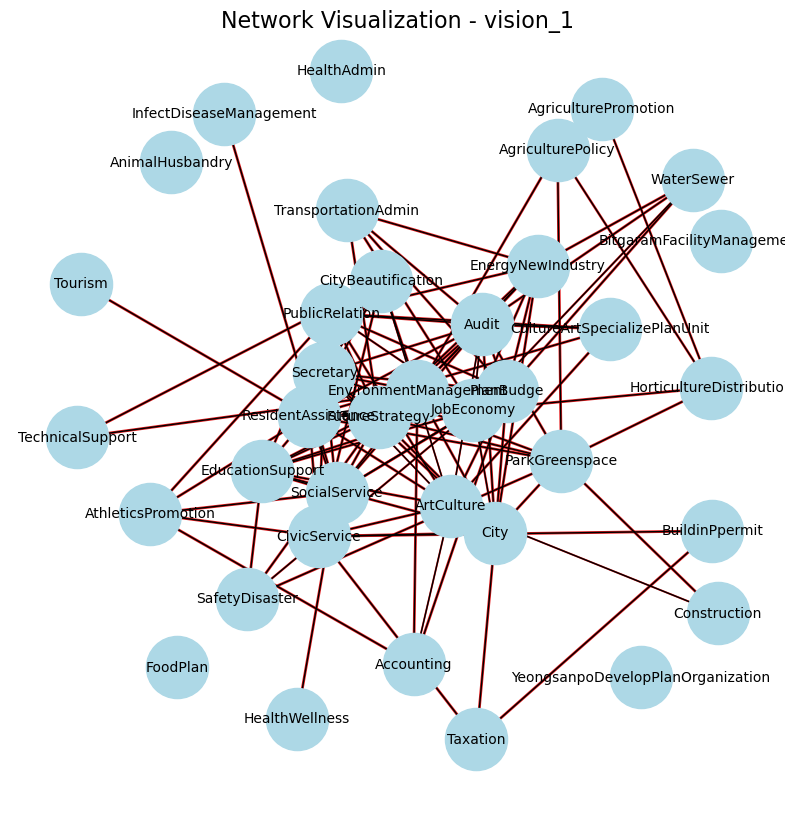

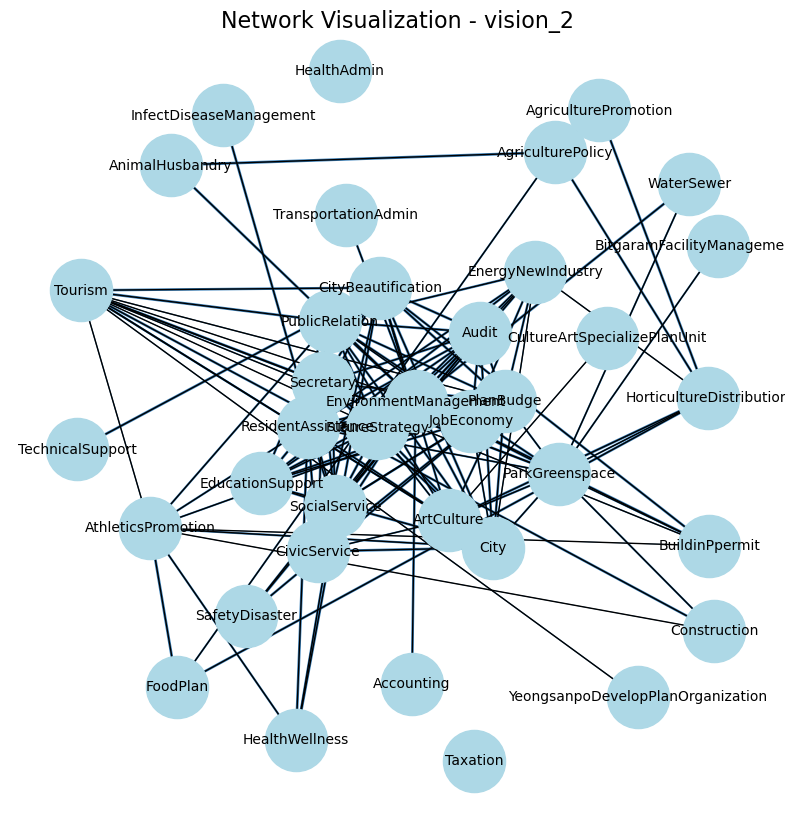

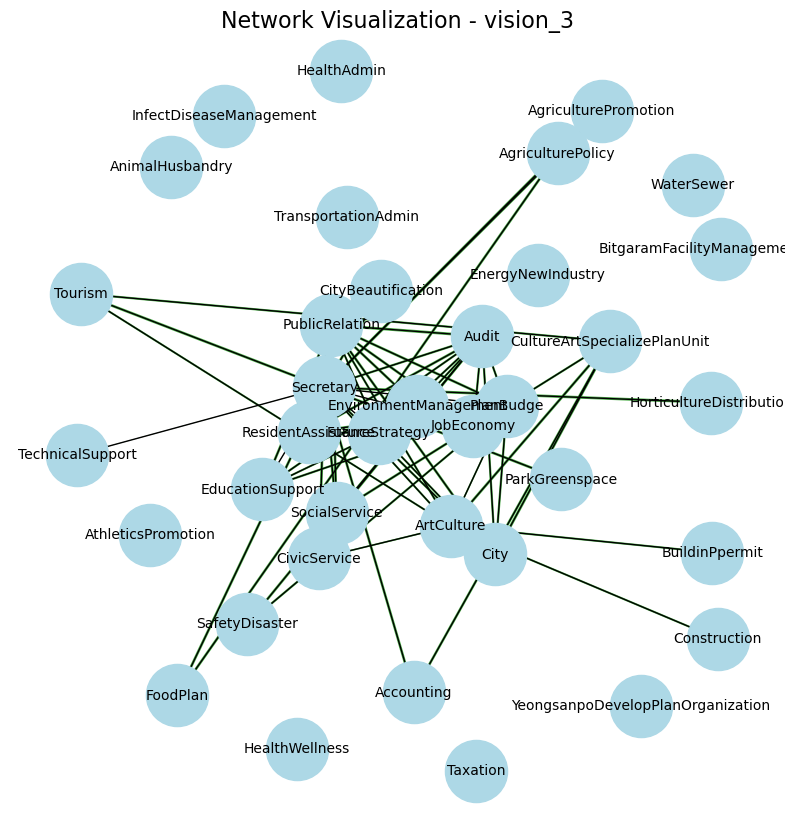

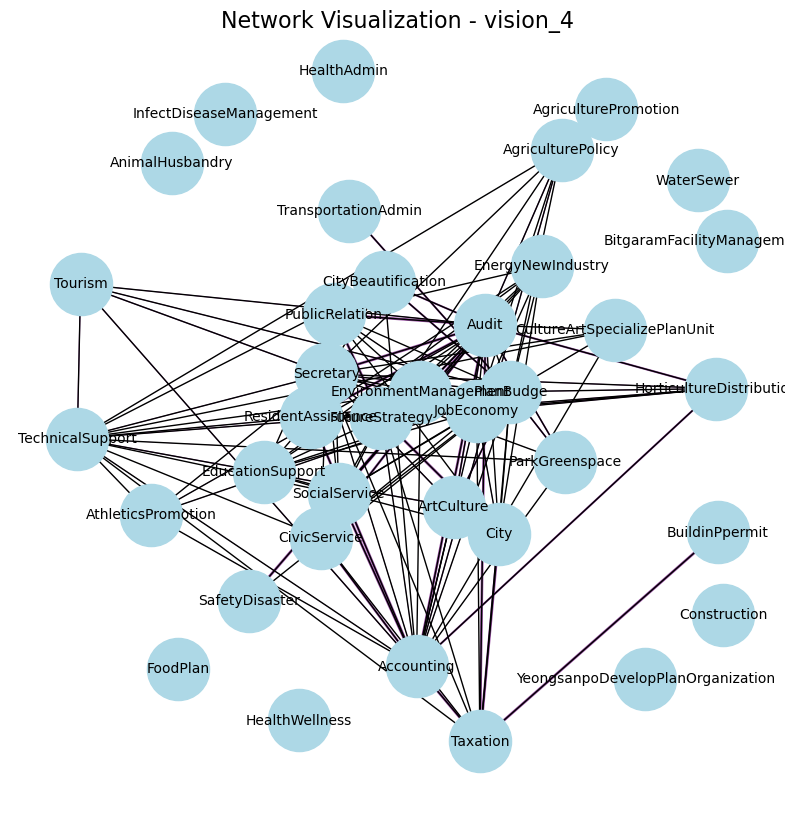

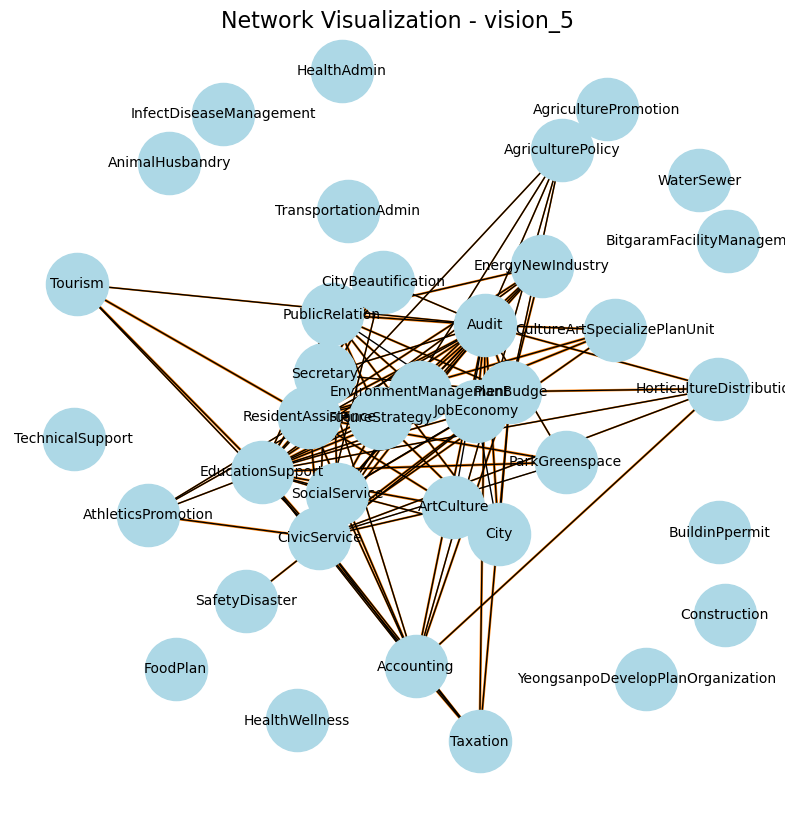

In [68]:
layer_colors = plt.cm.Set1(range(len(layer_networks)))
layer_to_color = {layer_name: color for layer_name, color in zip(layer_networks.keys(), layer_colors)}

pos = nx.spring_layout(list(layer_networks.values())[0], k=80.0, iterations=200)

for layer_name, G in layer_networks.items():
    plt.figure(figsize=(10, 10))

    edges = list(G.edges(data=True))
    weights = [d['weight'] for _, _, d in edges]

    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v) for u, v, _ in edges],
        edge_color=[layer_to_color[layer_name]] * len(edges),
        width=[w / max(weights) * 2 for w in weights], 
    )

    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
            node_size=2000, node_color="lightblue", font_size=10, font_color="black")
    
    plt.title(f"Network Visualization - {layer_name}", fontsize=16)
    plt.show()

G = nx.MultiGraph()

In [45]:
node_file = "Department_Collaborate_node.csv"
edges_folder = "Department_Collaborate_Vision/"

nodes_df = pd.read_csv(node_file, header=None, names=["id", "label"])

G = nx.MultiGraph()

for _, row in nodes_df.iterrows():
    G.add_node(row['id'], label=row['label'])

for edge_file in os.listdir(edges_folder):
    if edge_file.endswith("_edges.csv"):
        layer_name = edge_file.replace("_edges.csv", "")
        edge_path = os.path.join(edges_folder, edge_file)
        edges_df = pd.read_csv(edge_path)
        
        for _, row in edges_df.iterrows():
            G.add_edge(row['Start_Node'], row['End_Node'], weight=row['Weight'], layer=layer_name)

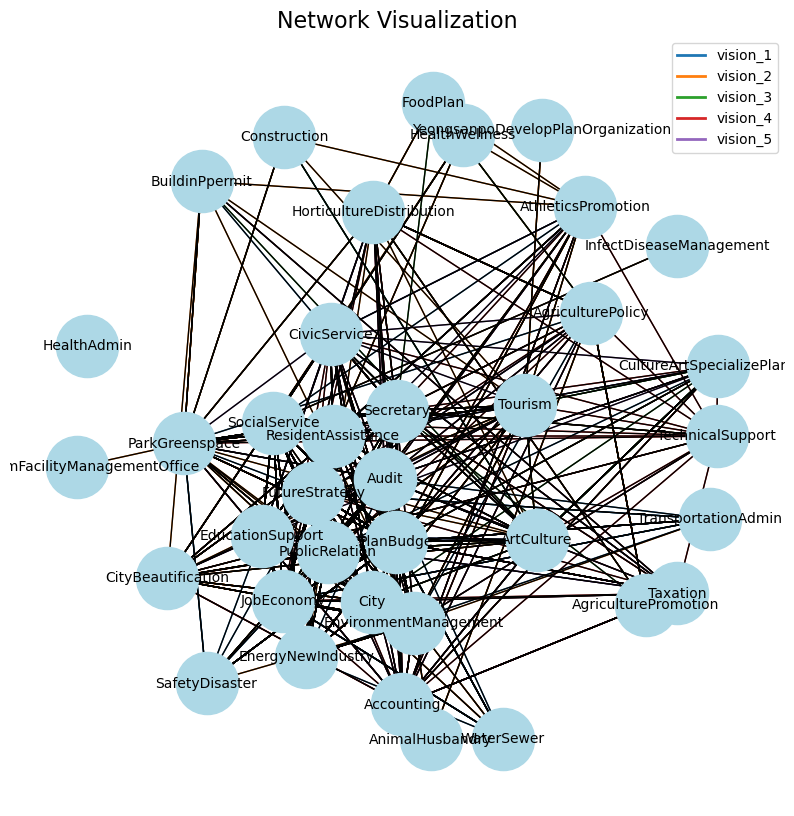

In [55]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=100.0, iterations=100)
# pos = nx.circular_layout(G)

layers = sorted({data['layer'] for _, _, data in G.edges(data=True)}) 
colors = plt.cm.tab10(range(len(layers)))
layer_to_color = {layer: color for layer, color in zip(layers, colors)}
for layer in layers:
    edges = [(u, v) for u, v, d in G.edges(data=True) if d['layer'] == layer]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=[layer_to_color[layer]] * len(edges), label=layer)

nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
        node_size=2000, node_color="lightblue", font_size=10, font_color="black")

plt.title("Network Visualization", fontsize=16)
plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=layer) for layer, color in layer_to_color.items()])
plt.show()

C:\Users\82102\AppData\Local\Temp\ipykernel_25008\2519168852.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(attr))


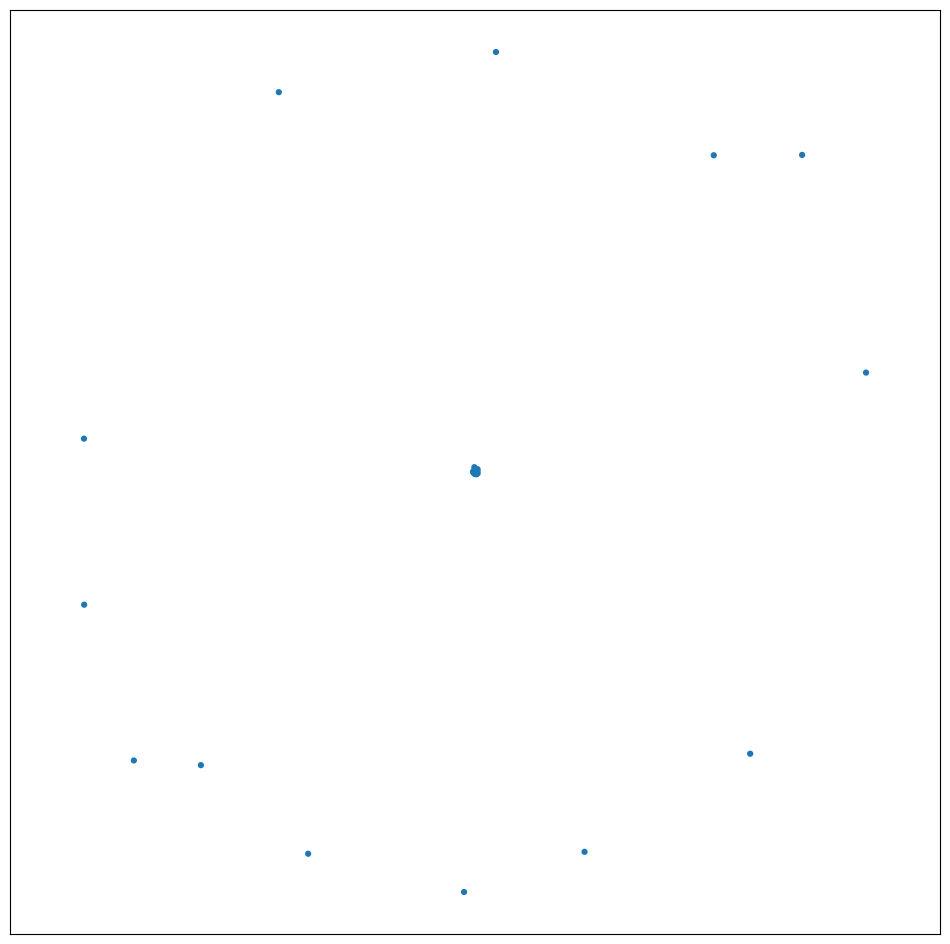

In [82]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import os
import numpy as np

def multilayer_layout(
    G: nx.Graph,
    subset_key="layer",
    layout=nx.spring_layout,
    separation: float = 2.0,
) -> dict:
    
    layers = {}
    for node, layer in nx.get_node_attributes(G, subset_key).items():
        layers[layer] = layers.get(layer, []) + [node]

    pos = {}
    for layer, nodes in layers.items():
        subgraph = G.subgraph(nodes)

        layer_pos = {
            node: node_pos + separation * np.array([0, int(layer)])
            for node, node_pos in layout(subgraph).items()
        }
        pos.update(layer_pos)
    return pos



def draw_multilayer_layout(
    layer_networks: dict,
    ax=None,
    layout=nx.spring_layout,
    separation=2.0,
    node_kwargs=dict(node_size=12),
    within_edge_kwargs=dict(style="solid", alpha=0.05),
    between_edge_kwargs=dict(style="dashed", alpha=0.65),
    cmap="Pastel2",
):

    all_graph = disjoint_union_all(list(layer_networks.values()))
    pos = multilayer_layout(
        all_graph,
        subset_key="layer",
        layout=layout,
        separation=separation,
    )


    attr = set(nx.get_node_attributes(all_graph, "layer").values())  
    color_space = np.linspace(0, 1, len(attr), 0)

    cmap = plt.cm.get_cmap("tab20", len(attr)) 

 
    node_colors = [cmap(all_graph.nodes[node]["layer"] % len(attr)) for node in all_graph.nodes()]


    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_nodes(all_graph, pos, node_color=node_colors, **node_kwargs)


    others = set()
    connectors = set()

    for node in all_graph.nodes():
        for neighbor in all_graph.neighbors(node):
            if all_graph.nodes[node]["layer"] != all_graph.nodes[neighbor]["layer"]:
                connectors.add((node, neighbor))
            else:
                others.add((node, neighbor))

    nx.draw_networkx_edges(all_graph, pos, edgelist=others, **within_edge_kwargs)
    nx.draw_networkx_edges(all_graph, pos, edgelist=connectors, **between_edge_kwargs)

    return ax


def disjoint_union_all(Gs: list[nx.Graph]) -> nx.Graph:
    G = Gs[0]
    for Gi in Gs[1:]:
        G = nx.disjoint_union(G, Gi)
    

    for idx, G in enumerate(Gs):
        for node in G.nodes():
            G.nodes[node]['layer'] = idx  
    return G


if __name__ == "__main__":
    nodes_file = "Department_Collaborate_node.csv"
    nodes_df = pd.read_csv(nodes_file, header=None, names=["id", "label"])
    edges_folder = "Department_Collaborate_Vision/"
    layer_networks = {}

    for edge_file in os.listdir(edges_folder):
        if edge_file.endswith("_edges.csv"):
            layer_name = edge_file.replace("_edges.csv", "")
            edge_path = os.path.join(edges_folder, edge_file)
            edges_df = pd.read_csv(edge_path)

            G = nx.Graph()

            for _, row in nodes_df.iterrows():
                G.add_node(row['id'], label=row['label'])

            for _, row in edges_df.iterrows():
                G.add_edge(row['Start_Node'], row['End_Node'], weight=row['Weight'], layer=layer_name)

            layer_networks[layer_name] = G

    fig, ax = plt.subplots(figsize=(12, 12))
    draw_multilayer_layout(layer_networks, ax=ax)
    ax.axis("equal")
    ax.grid(False)
    plt.show()
